In [3]:

!pip install torchvision
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

import numpy as np 
import matplotlib.pyplot as plt

In [5]:
train_data = MNIST(root='data/', download=True, transform=ToTensor())
mnist_testset_data = MNIST(root='./data', train=False, download=True, transform=ToTensor())
len(mnist_testset_data)
mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset_data, [int(0.9 * len(mnist_testset_data)), int(0.1 * len(mnist_testset_data))])
print("Training dataset size: ", len(train_data))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


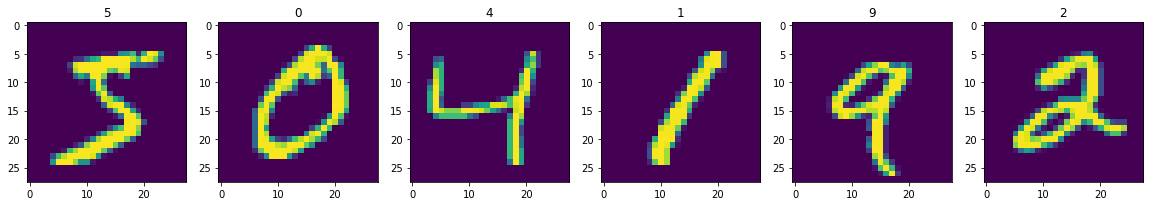

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)
from torchvision import transforms
fig=plt.figure(figsize=(20, 10))
for i in range(0, 6):
    img = transforms.ToPILImage(mode='L')(train_data[i][0])
    fig.add_subplot(1, 6, i+1)
    plt.title(train_data[i][1])
    plt.imshow(img)
plt.show()

In [7]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(1600, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

In [8]:
model = CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

if(torch.cuda.is_available()):
  model.cuda()

In [9]:
no_epochs = 100
train_loss = list()
val_loss = list()
best_val_loss = 1


Epoch: 1/100, Train Loss: 0.24254035, Val Loss: 0.04808356, Val Accuracy: 0.98444444
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.04808356

Epoch: 2/100, Train Loss: 0.07672221, Val Loss: 0.02872231, Val Accuracy: 0.99044444
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.02872231

Epoch: 3/100, Train Loss: 0.05507788, Val Loss: 0.02686594, Val Accuracy: 0.99122222
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.02686594

Epoch: 4/100, Train Loss: 0.04506327, Val Loss: 0.02492444, Val Accuracy: 0.99155556
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.02492444

Epoch: 5/100, Train Loss: 0.03656038, Val Loss: 0.02271056, Val Accuracy: 0.99222222
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.02271056

Epoch: 6/100, Train Loss: 0.03190994, Val Loss: 0.02476860, Val Accuracy: 0.99244444

Epoch: 7/100, Train Loss: 0.02602262, Val Loss: 0.02124535, Val Accuracy: 0.9941111

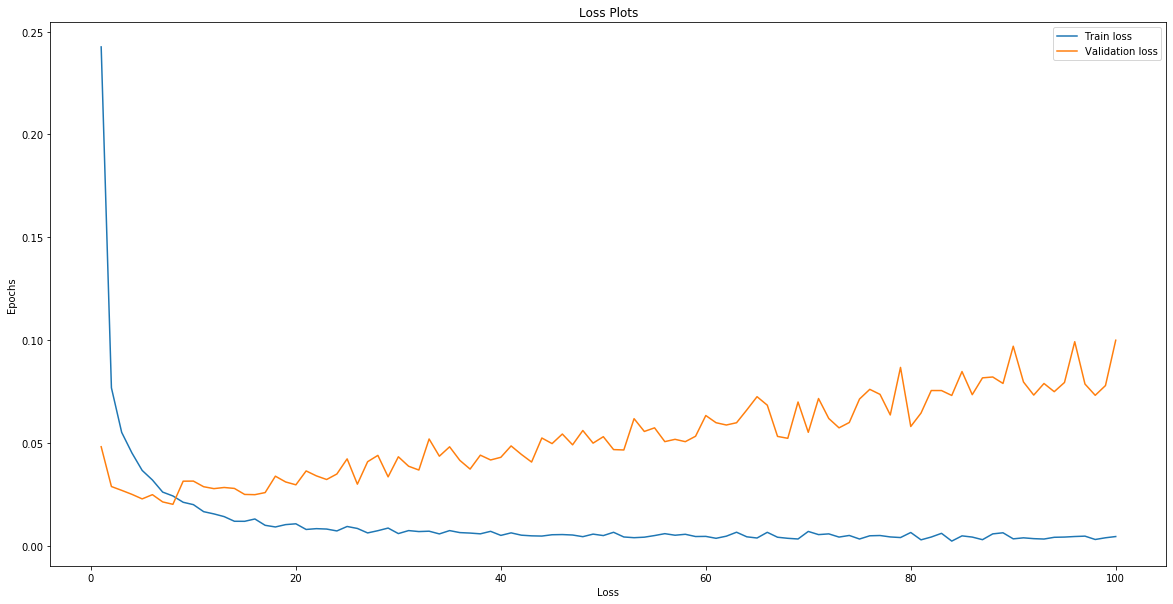

In [10]:
for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # validation
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")

fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [14]:
#(2)  Please find the params for the first Model ( (kernel size^2 + bias)*number of Filters = (5*5 +1)*32 =832) for the first Conv
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
|  conv_1.weight  |    800     |
|   conv_1.bias   |     32     |
|  conv_2.weight  |   51200    |
|   conv_2.bias   |     64     |
| linear_1.weight |   204800   |
|  linear_1.bias  |    128     |
| linear_2.weight |    1280    |
|  linear_2.bias  |     10     |
+-----------------+------------+
Total Trainable Params: 258314


258314

In [15]:
# test model
model.load_state_dict(torch.load("model.dth"))
model.eval()

# store correct predictions
correct_results = list()
# store wrong predictions
wrong_results = list()
total = 0
for itr, (image, label) in enumerate(test_dataloader):

    if (torch.cuda.is_available()):
        image = image.cuda()
        label = label.cuda()

    pred = model(image)
    pred = torch.nn.functional.softmax(pred, dim=1)

    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
            correct_results.append((image, torch.max(p.data, 0)[1]))

        else:
          wrong_results.append((image, torch.max(p.data, 0)[1]))

test_accuracy = total / len(mnist_testset)
print('Test accuracy {:.8f}'.format(test_accuracy))

Test accuracy 0.99200000


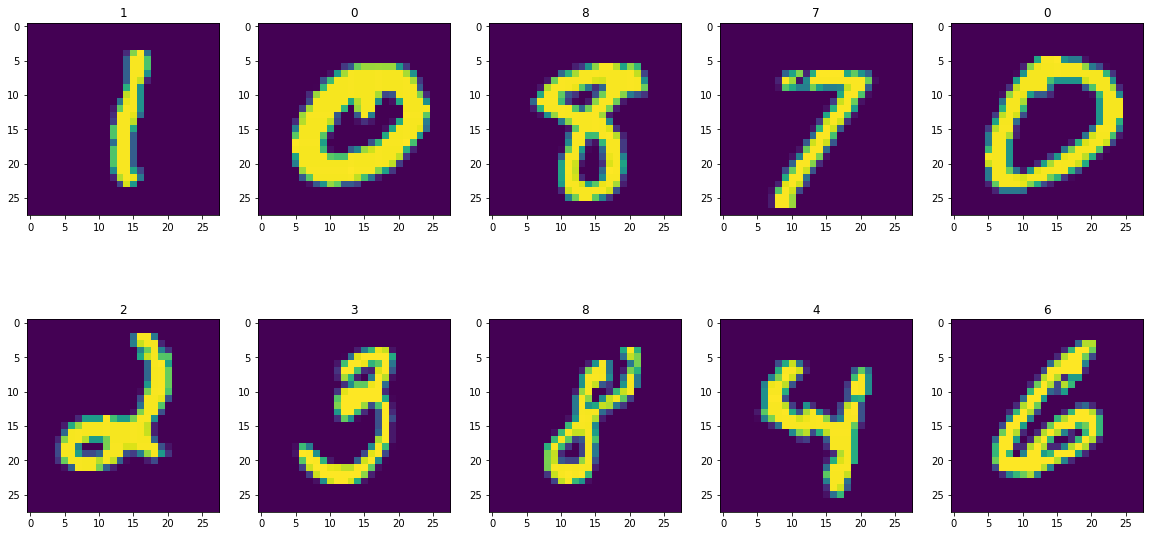

In [17]:
# visualize correct results
fig=plt.figure(figsize=(20, 10))
for i in range(1, min(11, len(correct_results))):

    img = transforms.ToPILImage(mode='L')(correct_results[0][0][i])
    fig.add_subplot(2, 5, i)
    plt.title(correct_results[i][1].item())
    plt.imshow(img)
plt.show()

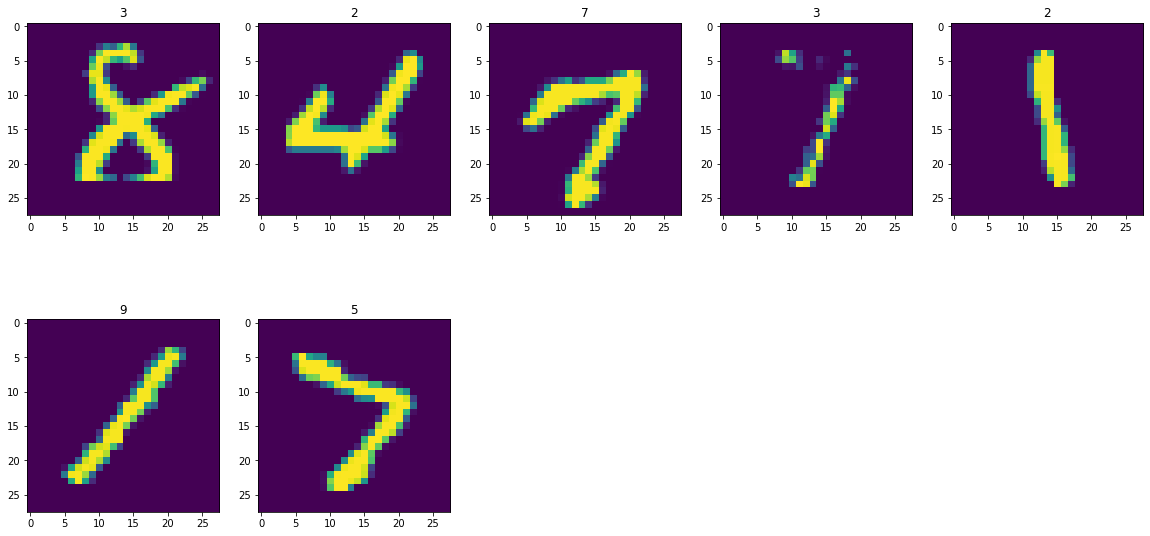

In [19]:
# visualize wrong results
fig=plt.figure(figsize=(20, 10))
for i in range(1, min(11, len(wrong_results))):

    img = transforms.ToPILImage(mode='L')(wrong_results[0][0][i])
    fig.add_subplot(2, 5, i)
    plt.title(wrong_results[i][1].item())
    plt.imshow(img)
plt.show()

In [36]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

In [38]:
no_epochs = 100
train_loss = list()
val_loss = list()
best_val_loss = 1

In [41]:
model_st = CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_st.parameters(), lr = 0.001)

if(torch.cuda.is_available()):
  model_st.cuda()


Epoch: 1/100, Train Loss: 0.40582807, Val Loss: 0.10383646, Val Accuracy: 0.96922222
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.10383646

Epoch: 2/100, Train Loss: 0.12255316, Val Loss: 0.07034927, Val Accuracy: 0.97700000
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.07034927

Epoch: 3/100, Train Loss: 0.08532069, Val Loss: 0.06743632, Val Accuracy: 0.97911111
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.06743632

Epoch: 4/100, Train Loss: 0.06730754, Val Loss: 0.04616905, Val Accuracy: 0.98433333
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.04616905

Epoch: 5/100, Train Loss: 0.05538790, Val Loss: 0.04325799, Val Accuracy: 0.98622222
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.04325799

Epoch: 6/100, Train Loss: 0.04863934, Val Loss: 0.03688444, Val Accuracy: 0.98766667
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.03688444

Epo

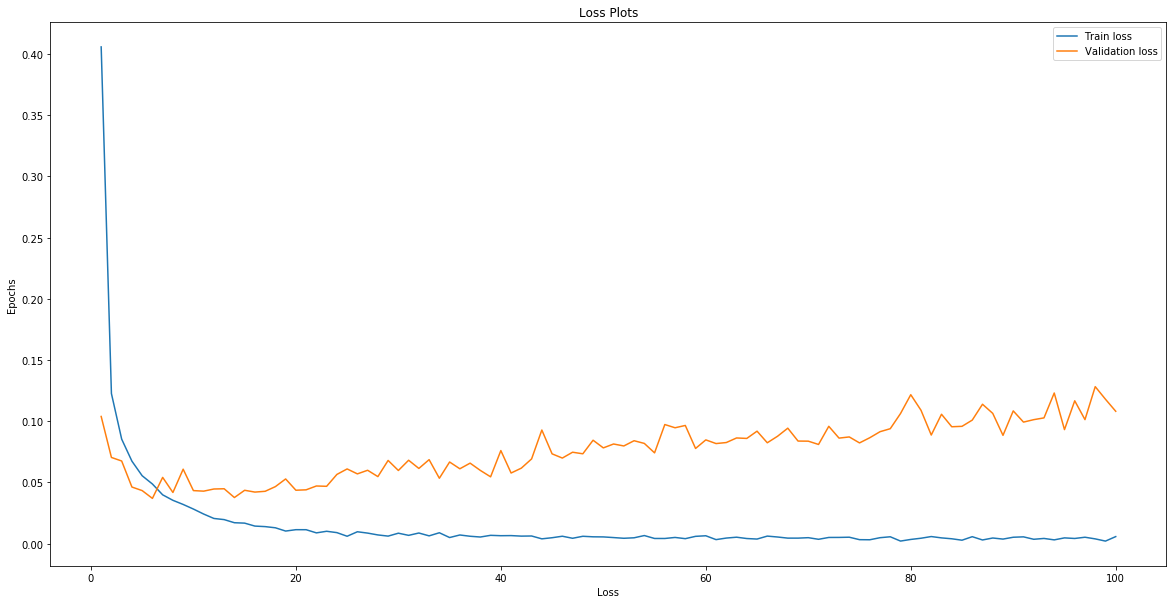

In [42]:
for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model_st.train()
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = model_st(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # validation
    model_st.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model_st(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model_st.state_dict(), "model_st.dth")

fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [43]:
# test model
model_st.load_state_dict(torch.load("model_st.dth"))
model_st.eval()

# store correct predictions
correct_results = list()
# store wrong predictions
wrong_results = list()
total = 0
for itr, (image, label) in enumerate(test_dataloader):

    if (torch.cuda.is_available()):
        image = image.cuda()
        label = label.cuda()

    pred = model_st(image)
    pred = torch.nn.functional.softmax(pred, dim=1)

    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
            correct_results.append((image, torch.max(p.data, 0)[1]))

        else:
          wrong_results.append((image, torch.max(p.data, 0)[1]))

test_accuracy = total / len(mnist_testset)
print('Test accuracy {:.8f}'.format(test_accuracy))

Test accuracy 0.99100000


In [44]:
#(2)  Please find the params for the Second Model 

from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model_st)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
|  conv_1.weight  |    800     |
|   conv_1.bias   |     32     |
|  conv_2.weight  |   51200    |
|   conv_2.bias   |     64     |
| linear_1.weight |    8192    |
|  linear_1.bias  |    128     |
| linear_2.weight |    1280    |
|  linear_2.bias  |     10     |
+-----------------+------------+
Total Trainable Params: 61706


61706

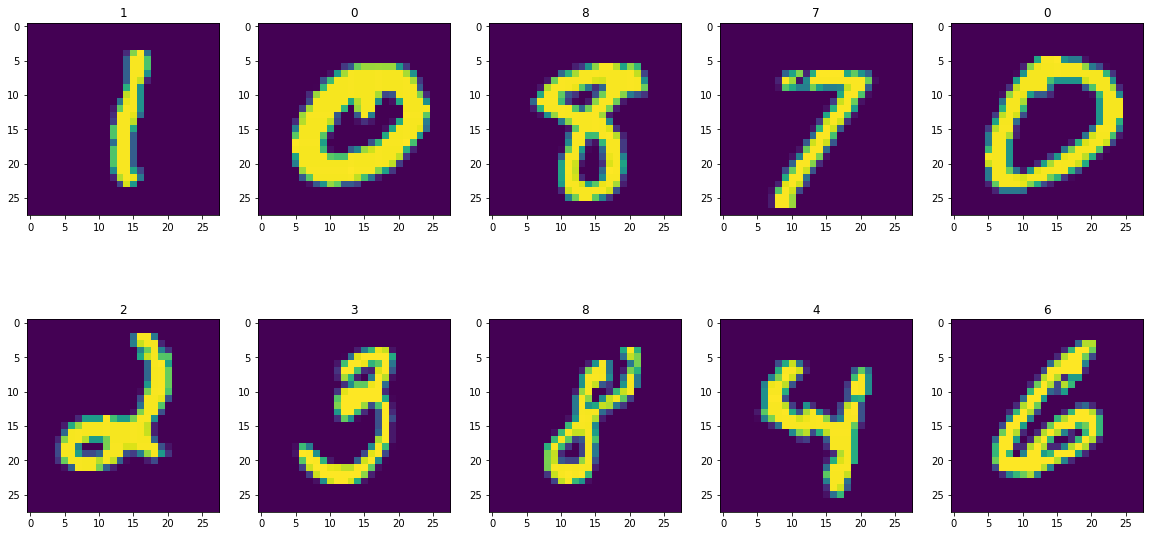

In [46]:
# visualize correct results
fig=plt.figure(figsize=(20, 10))
for i in range(1, min(11, len(correct_results))):

    img = transforms.ToPILImage(mode='L')(correct_results[0][0][i])
    fig.add_subplot(2, 5, i)
    plt.title(correct_results[i][1].item())
    plt.imshow(img)
plt.show()

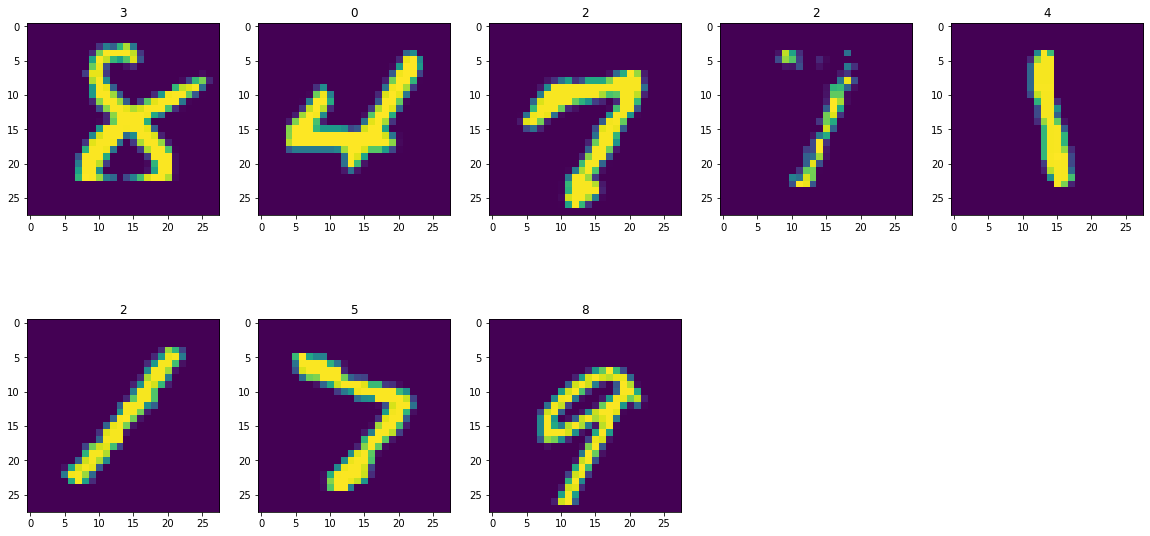

In [48]:
# visualize wrong results
fig=plt.figure(figsize=(20, 10))
for i in range(1, min(11, len(wrong_results))):

    img = transforms.ToPILImage(mode='L')(wrong_results[0][0][i])
    fig.add_subplot(2, 5, i)
    plt.title(wrong_results[i][1].item())
    plt.imshow(img)
plt.show()